# G0W0 approximation

In this note, we explore some properties of the G0W0 approximation

## 1. RPA interaction
$$
W_0=\frac{v_q}{1-v_q\Pi_0},
$$
where $v_q$ is the Coulomb interaction, and $\Pi_0$ is the polarization of free electrons.

In [1]:
using Revise
using ElectronGas
using GreenFunc
using LaTeXStrings
using Plots, Parameters

In [2]:
beta = 1000.0
rs = 5.0
d = 3
para=Parameter.rydbergUnit(1/beta, rs, d);

In [3]:
#warning: take a minute or so.
sigma_dyn, sigma_ins = SelfEnergy.G0W0(para, minK = 1e-6, Nk=12, order=6);
sigma_ωn = sigma_dyn |> to_dlr |> to_imfreq;
wgrid, kgrid = sigma_ωn.mesh
dlr = wgrid.representation
ωn_grid = wgrid.representation.ωn;
kFidx = searchsortedfirst(kgrid.grid, para.kF);

### 1.1 Frequency-dependent Self-energy (dynamic part only)

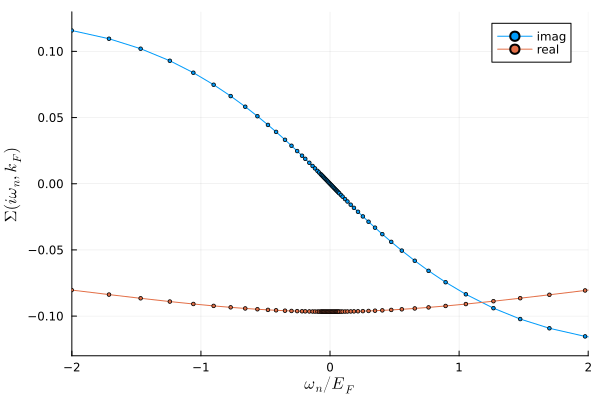

In [4]:
plot(ωn_grid/para.EF, imag(sigma_ωn[:, kFidx]),marker=2, label="imag", xlabel=L"$\omega_n/E_F$", ylabel=L"$\Sigma(i\omega_n, k_F)$", xlims=(-2, 2))
plot!(ωn_grid/para.EF, real(sigma_ωn[:, kFidx]),marker=2, label="real")

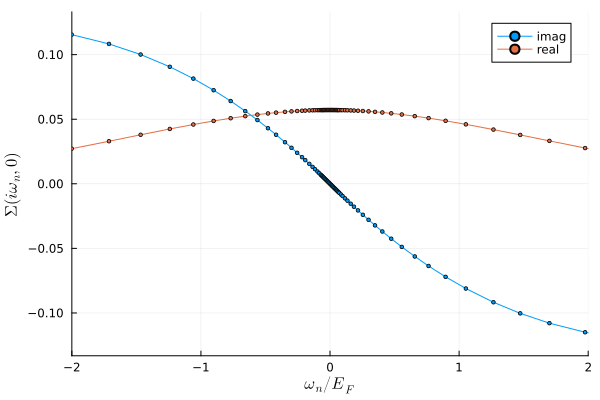

In [6]:
plot(ωn_grid/para.EF, imag(sigma_ωn[:, 1]), marker=2, label="imag", xlabel=L"$\omega_n/E_F$", ylabel=L"$\Sigma(i\omega_n, 0)$", xlims=(-2, 2))
plot!(ωn_grid/para.EF, real(sigma_ωn[:, 1]), marker=2, label="real")

### 1.2 Momentum-dependent Self-energy (instant + dynamic)

63


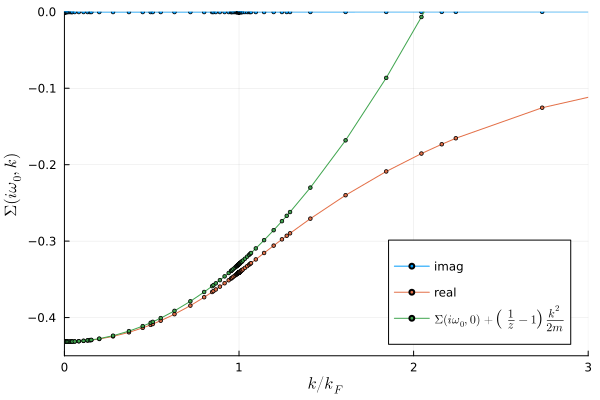

In [8]:
widx = searchsortedfirst(dlr.n, 0)
println(widx)

sig = sigma_ωn[widx, :] .+ sigma_ins[1, :]
plot(kgrid.grid/para.kF, imag(sig), marker=2, label="imag", xlabel=L"$k/k_F$", ylabel=L"$\Sigma(i\omega_0, k)$", ylims=[-0.45, 0.0], xlims=[0.0, 3], legend =:bottomright)
plot!(kgrid.grid/para.kF, real(sig), marker=2, label="real")
x = kgrid.grid
z, _ = SelfEnergy.zfactor(para, sigma_ωn)
plot!(x/para.kF, x.^2/(2*para.me)*(1/z-1).+real(sig[1]), marker=2, label=L"$\Sigma(i\omega_0, 0)+\left(\frac{1}{z}-1\right)\frac{k^2}{2m}$")

### 1.3 Z-factor and Effective mass

Quasiparticle effective mass can be extracted from the quasiparticle propagator,
$$G(k, i\omega)=\frac{-1}{i\omega-k^2/{2m}+\mu-\Sigma(k, i\omega)}$$
Near the Fermi surface, 
$$Re\Sigma(k, i\omega)=Re\Sigma(k_F, 0)+\frac{\partial Re\Sigma(k_F, 0)}{\partial k} (k-k_F) + ...$$
and,
$$Im\Sigma(k, i\omega)=Im\Sigma(k_F, 0^+)\cdot \text{sgn}(\omega)+\frac{\partial Im\Sigma(k_F, 0^+)}{\partial \omega}\cdot \omega  + ...$$
so that the quasiparticle propagator is renormalized to the form,
$$G(k, i\omega) = \frac{-z}{i\omega-v_F^*(k-k_F)+i\eta \cdot \text{sgn}(\omega)}$$
the wave-function renormalization factor,
$$z=\frac{1}{1-\frac{\partial Im\Sigma(k_F, 0^+)}{\partial \omega}}=\lim_{T\rightarrow 0} \frac{1}{1-\frac{\Sigma(i\omega_2, k_F)-\Sigma(i\omega_1, k_F)}{i2\pi T}}$$
and the quasiparticle life time,
$$\eta = z\cdot Im\Sigma(k_F, 0^+)$$
and the effective mass,
$$\frac{m}{m^*}=z \cdot \left(1+\frac{m}{k_F}\frac{\partial Re\Sigma(k_F, 0)}{\partial k}\right)$$

rs = 5.000000000000001 has Z factor = 0.5918707137703781


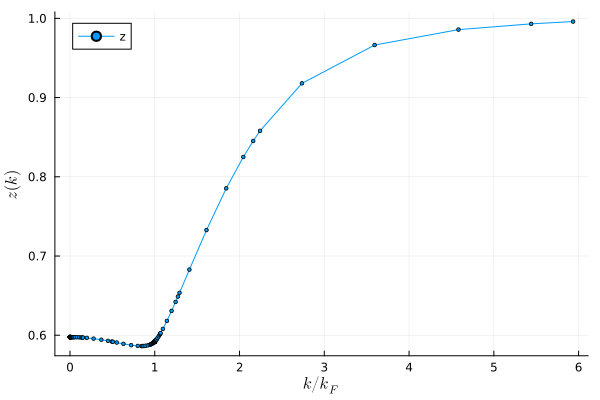

In [9]:
w0idx = searchsortedfirst(dlr.n, 0)
zfactor_wn = @. 1 / (1 - imag(sigma_ωn[w0idx+1, :]-sigma_ωn[w0idx, :]) / (2π) * para.β)
zfactor = zfactor_wn[kFidx]
println("rs = $(para.rs) has Z factor = ", zfactor)
plot(kgrid.grid/para.kF, zfactor_wn, marker=2, label="z", xlabel=L"$k/k_F$", ylabel=L"$z(k)$")

### 1.3.1 G0W0

In [12]:
#Warning: take a few minutes
zfactor = []
mass = []
rslist = [0.5, 1.0, 3.0, 4.0, 5.0]
plt =plot(xlims=(0.0, 2.01), ylims=(1.0, 1.8), legend = :topright, size=(600,600))
for _rs in rslist
    param = Parameter.rydbergUnit(1.0/beta/2, _rs, d)
    @unpack me, β, kF = param
    sigma_dyn, sigma_ins = SelfEnergy.G0W0(param, minK = 1e-7, Nk=16, order=6);
    sigma_wn = sigma_dyn |> to_dlr |> to_imfreq;

    z, _ = SelfEnergy.zfactor(param, sigma_wn)
    mratio, _ = SelfEnergy.massratio(param, sigma_dyn, sigma_ins)

    println("rs = $_rs => $z, with m*/m = $mratio")
    push!(zfactor, z)
    push!(mass, mratio)
    
    
    zfactor_wn = @. 1 / (1 - imag(sigma_wn[w0idx+1, :]-sigma_wn[w0idx, :]) / (2π) * param.β)
    plot!(plt, kgrid.grid/param.kF, 1 ./ zfactor_wn, marker=0, linewidth=2, label="rₛ = $_rs", xlabel=L"$k/k_F$", ylabel=L"$\frac{1}{z_k}=\frac{\partial G^{-1}(\omega_0, k)}{\partial \omega}$")
end
#savefig(plt, "G0W0_z.pdf")
display(plt)

rs = 0.5 => 0.9226090204113138, with m*/m = 0.9678509693636314
rs = 1.0 => 0.8603719175950142, with m*/m = 0.9718827268360345
rs = 3.0 => 0.6930238057874474, with m*/m = 1.0174682213993336
rs = 4.0 => 0.6370003335890603, with m*/m = 1.0394165559280977
rs = 5.0 => 0.5915854357607926, with m*/m = 1.0588987312553058


To compare with, the following are the data from literature. 
- https://journals.aps.org/prb/abstract/10.1103/PhysRevB.77.035131
- https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.110402

There are some difference, it is probably caused by the temperature effect. More careful benchmarked is needed in future.
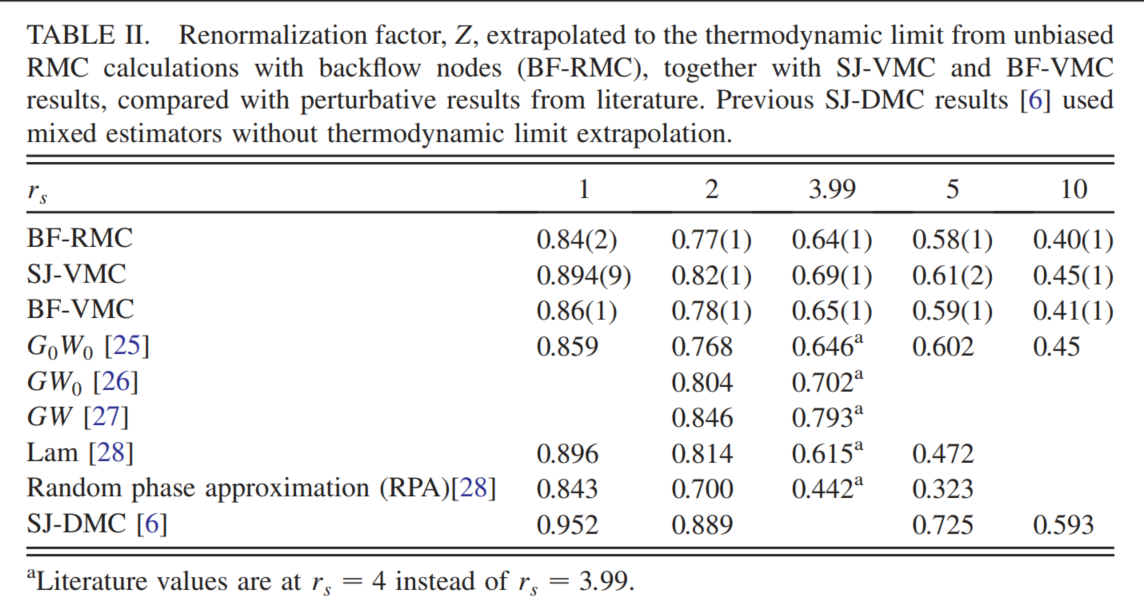

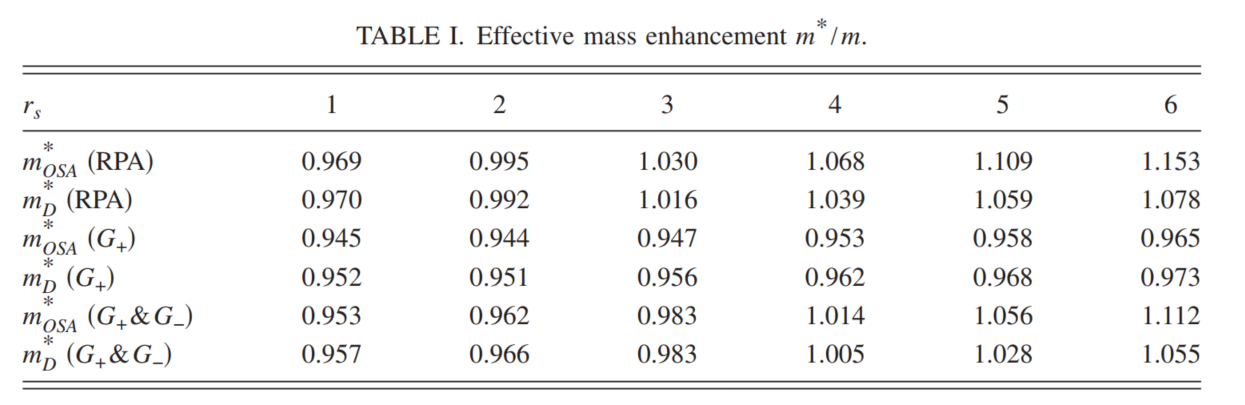

### 1.3.2 G0KO

In [13]:
# KO interaction
zfactor = []
mass = []
rslist = [0.5, 1.0, 3.0, 4.0, 5.0, 10.0, 20.0]
plt =plot(xlims=(0.0, 6.01), ylims=(0.2, 1.0), legend = :bottomright)
for _rs in rslist
    param = Parameter.rydbergUnit(1.0/beta/2, _rs, d)
    @unpack me, β, kF = param
    sigma_dyn, sigma_ins = SelfEnergy.G0W0(param, minK = 1e-6, Nk=16, order=6, int_type=:ko);
    sigma_wn = sigma_dyn |> to_dlr |> to_imfreq;

    z, _ = SelfEnergy.zfactor(param, sigma_wn)
    mratio, _ = SelfEnergy.massratio(param, sigma_dyn, sigma_ins)

    println("rs = $_rs => $z, with m*/m = $mratio")
    push!(zfactor, z)
    push!(mass, mratio)
    
    zfactor_wn = @. 1 / (1 - imag(sigma_wn[w0idx+1, :]-sigma_wn[w0idx, :]) / (2π) * param.β)
    plot!(plt, kgrid.grid/param.kF, zfactor_wn, marker=0, linewidth=2, label="rs=$_rs", xlabel=L"$k/k_F$", ylabel=L"$z(k)$")
end
#savefig(plt, "G0KO_z.pdf")
display(plt)

rs = 0.5 => 0.925189714553559, with m*/m = 0.9638872885472264
rs = 1.0 => 0.8658248509377611, with m*/m = 0.9631518402804752
rs = 3.0 => 0.7088872779913278, with m*/m = 0.988944545440782
rs = 4.0 => 0.6572652727675898, with m*/m = 1.0005706018551648
rs = 5.0 => 0.6154158970789481, with m*/m = 1.0101534978493174
rs = 10.0 => 0.48051902501997634, with m*/m = 0.981004414200254
rs = 20.0 => 0.348383383554235, with m*/m = 0.9947900279052805


0.5
rs = 0.5 => 0.9226090399410031, with m*/m = 0.967836335707776
1.0
rs = 1.0 => 0.8603720207797995, with m*/m = 0.9718432954150146
3.0
rs = 3.0 => 0.693024008862456, with m*/m = 1.0171638469643622
4.0
rs = 4.0 => 0.6370006397861899, with m*/m = 1.0388706440721847
5.0
rs = 5.0 => 0.5915857919305341, with m*/m = 1.0581320068084474


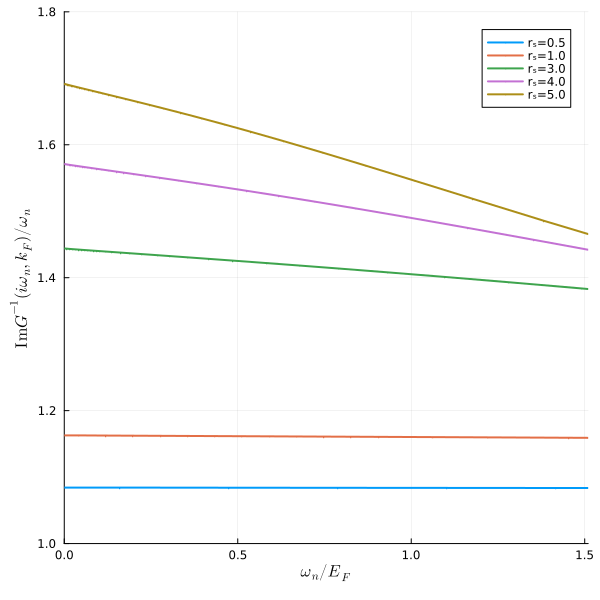

In [14]:
#Warning: take a few minutes
zfactor = []
mass = []
rslist = [0.5, 1.0, 3.0, 4.0, 5.0]
plt =plot(xlims=(0.0, 1.51), ylims=(1.0, 1.8), legend = :topright, size=(600,600))
for _rs in rslist
    println(_rs)
    param = Parameter.rydbergUnit(1.0/beta/2, _rs, d)
    @unpack me, β, kF = param
    sigma_dyn, sigma_ins = SelfEnergy.G0W0(param, minK = 1e-6, Nk=16, order=6, int_type=:rpa);
    sigma_wn = sigma_dyn |> to_dlr |> to_imfreq;
    dlr = sigma_wn.mesh[1].representation

    z, _ = SelfEnergy.zfactor(param, sigma_wn)
    mratio, _ = SelfEnergy.massratio(param, sigma_dyn, sigma_ins)

    println("rs = $_rs => $z, with m*/m = $mratio")
    push!(zfactor, z)
    push!(mass, mratio)
    
    plot!(plt, dlr.ωn/para.EF, 1.0 .- imag(sigma_wn[:, kFidx])./dlr.ωn, marker=0, linewidth=2.0, label="rₛ=$(_rs)", xlabel=L"$\omega_n/E_F$", ylabel=L"$\operatorname{Im} G^{-1}(i\omega_n, k_F)/\omega_n$")
end
#savefig(plt, "G0W0_w.pdf")
display(plt)

0.5
1.0
3.0
4.0
5.0


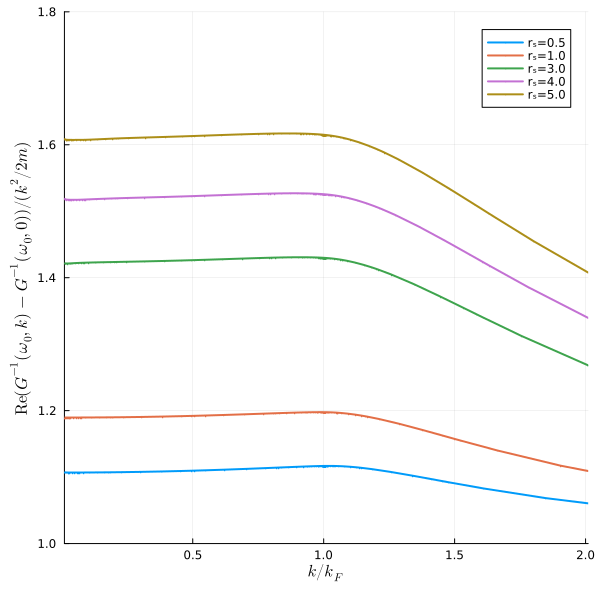

In [17]:
#Warning: take a few minutes
zfactor = []
mass = []
rslist = [0.5, 1.0, 3.0, 4.0, 5.0]
#plt =plot(xlims=(0.0, 2.01), ylims=(0.2, 1.0), legend = :topright)
plt =plot(xlims=(0.01, 2.01), ylims=(1.0, 1.8), legend = :topright, size=(600,600))
for _rs in rslist
    println(_rs)
    param = Parameter.rydbergUnit(1.0/beta/2, _rs, d)
    @unpack me, β, kF = param
    sigma_dyn, sigma_ins = SelfEnergy.G0W0(param, minK = 1e-6, Nk=16, order=6, int_type=:rpa);
    sigma_wn = sigma_dyn |> to_dlr |> to_imfreq;
    dlr = sigma_wn.mesh[1].representation
    kgrid = sigma_wn.mesh[2]
    w0idx = searchsortedfirst(dlr.n, 0)
    sig = sigma_wn[w0idx, :] .+ sigma_ins[1, :]
    
    plot!(plt, kgrid.grid/param.kF, 1.0 .+ (real(sig) .- real(sig[1]))./(kgrid.grid .^2/(2*me)), marker=0, linewidth=2.0, label="rₛ=$(_rs)", xlabel=L"$k/k_F$", ylabel=L"$\operatorname{Re} (G^{-1}(\omega_0, k)-G^{-1}(\omega_0, 0))/(k^2/2m)$")
end
#savefig(plt, "G0W0_k.pdf")
display(plt)